In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg.dsolve import spsolve
from scipy.sparse.linalg import bicgstab, bicg, cg, cgs, gmres, lgmres, minres, qmr, gcrotmk
import matplotlib.animation as animation
from IPython.display import HTML
from scipy import stats
import time
start_time = time.time()
%matplotlib inline
import multiprocessing 

In [2]:
def primal(mu,impx):
    eps = 1e-10
    u = np.zeros(Nx)
    tarray = (mu>eps)
    u[tarray]= impx[tarray]/mu[tarray]
    mu[np.logical_not(tarray)] = 0
    impx = u*mu
    return mu,u,impx

def fnum_x(h,mu,impx):
    #Remise dans les variables primales
    mu,u,impx = primal(mu,impx)
    fmu = np.zeros(Nx)
    fimpx = np.zeros(Nx)
    #Initialisation aux variables centrees
    mug = np.roll(mu,1)
    impxg = np.roll(impx,1)
    ug = np.roll(u,1)
    #Moyenne de Roe
    uc = np.zeros(Nx)
    tarray = (np.sqrt(mu)+np.sqrt(mug)>0)
    uc[tarray] = (np.sqrt(mu[tarray])*u[tarray]+np.sqrt(mug[tarray])*ug[tarray])/ \
        (np.sqrt(mu[tarray])+np.sqrt(mug[tarray]))
    #Calcul des valeurs propres
    l1 = uc + sqrtTemp*np.ones(Nx)
    l2 = uc - sqrtTemp*np.ones(Nx)
    l3 = uc
    #Decentrement amont pour chacun des invariants de Riemann
    #Wave strengths
    r1 = (-(mu-mug)*l2+(impx-impxg))/(2*sqrtTemp)
    r2 = ((mu-mug)*l1-(impx-impxg))/(2*sqrtTemp)
    r1 = np.abs(l1)*r1
    r2 = np.abs(l2)*r2
    #Calcul des flux
    fmu = 0.5*(impx+impxg - (r1+r2))
    fimpx = 0.5*(impx*u+Temp*mu+impxg*ug+Temp*mug - (r1*l1 + r2*l2))
    return fmu, fimpx

def solve_adv_x(h,mu,impx):
    fmu, fimpx = fnum_x(h,mu,impx)
    #Mise a jour des valeurs
    mu += h/dx*(fmu-np.roll(fmu,-1))
    impx += h/dx*(fimpx-np.roll(fimpx,-1))
    mu,u,impx = primal(mu,impx)
    return mu,impx,u

In [3]:
def find_first(test):
    try:
        ans = np.min(X[test])
    except:
        ans = Nx+1
    
    return ans

def coeffs_P3():
    a = (lbda+f0)
    b = (f0**2+lbda*f0 -f0*F0)
    c = -F0*f0*(lbda+2*f0)
    d = (F0*f0)**2
    return [a,b,c,d]
def coeffs_Q():
    a,b,c,d = coeffs_P3()
    return [a, 2*b, 3*c, 4*d]
def vitesse_theorique(sign=-1):
    y = np.min( np.roots(coeffs_Q()))
    p3_y = np.polyval(coeffs_P3(),y)
    s_sel = sign*np.sqrt(-Temp*(y**4)/p3_y)
    return s_sel


In [4]:
Nx = 20000
Lx = 1000
dx = Lx/(Nx-1)
cfl = 1
T = 100
Nprint = 1000
dt_print = T/Nprint
mu_lim = 0.4

lbda = .3
Temp = 10
sqrtTemp = np.sqrt(Temp)
B = .5
F0 = .8
f0 = 1

def f(c):
    return c
R = Lx/40

X = np.linspace(0,Lx,Nx)
mu0 = np.zeros(Nx)
mu0[np.abs(X-Lx/2)<R]=0.01
u0 = np.zeros(Nx)
#v0 = np.zeros(Nx)
rho0 = np.zeros(Nx)
C0 = np.full((Nx),f0)

def F(*args):
    return F0
# plt.plot(rho0)

In [5]:
#Debut du calcul
#Initialisation
def solve():
    mu = mu0
    u  = u0
    rho = rho0
    C  = C0
    Mu_mem= [mu]
    U_mem = [u]
    Rho_mem = [rho0]
    C_mem = [C]
    T_mem = [0]

    #Variables conservatives
    impx = mu*u
    #Boucle en temps
    t_print = 0
    n_print = 0
    t = 0
    n = 0
    while t<T:
        #On détermine le pas de temps
        dt_adv = cfl*dx/(np.max(np.abs(u))+sqrtTemp)
        dt = dt_adv
        #dt = 1.e-1
        t += dt
        t = min(T,t)
        n+=1

        #Résolution de l'advection par splitting de Strang (en variables conservatives)
        mu,impx,u=solve_adv_x(dt,mu,impx)
        #Termes de réaction
        dxC = (C-np.roll(C,1))/(2*dx)
        #Termes de réaction
        #Resolution implicite de mu, impx, impy et rho (C fixé)
        a = dt**2*F(np.abs(u),Temp)
        b = 1 - dt*f(C) - dt**2*f(C)*F(np.abs(u),Temp) + dt*rho
        c = -mu - dt*f(C)*rho
        mu = (-b+np.sqrt(b**2-4*a*c))/(2*a)
        rho = rho+ dt*F(np.abs(u),Temp)*mu
        impx = (impx+dt*mu*dxC)/(1+dt*lbda+dt*rho)
        #Resolution implicite de C
        C = C/(1+dt*B*rho*C) 
        if  t > T*n_print/Nprint:
            Mu_mem +=[mu]
            Rho_mem +=[rho]
            C_mem +=[C]
            T_mem+=[t]
            n_print +=1
            #print('n=',n, 't=',t, 'dt=',dt, 'n_print=', n_print)
    
    first = np.zeros(len(Rho_mem))
    for i in range(len(Rho_mem)):
        first[i]=find_first(Rho_mem[i]>1) 
    front_start = len(T_mem)//2

    xfit = np.array(T_mem[front_start:])

    yfit = np.array(first[front_start:])
    filt = yfit > 50
    xfit,yfit = xfit[filt],yfit[filt]
    
    s_simu, intercept, r_value, p_value, std_err = stats.linregress(xfit,yfit)
    s_sel=vitesse_theorique(sign=-1)
    print('done')
    return Mu_mem, Rho_mem, C_mem, T_mem, s_simu, s_sel
    


In [6]:

#pool = multiprocessing.Pool()
#pool.map(multiprocessing_func, range(0,10))
#pool.close()

S_simu =[]
S_sel = []
for i in range(10):
    for j in range(5):
        lbda = .3+.1*i
        Temp = 10
        sqrtTemp = np.sqrt(Temp)
        B = .5
        F0 = .5+.1*j
        f0 = 1
        Mu_mem, Rho_mem, C_mem, T_mem, s_simu, s_sel = solve()
        S_simu += [s_simu]
        S_sel += [s_sel]

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


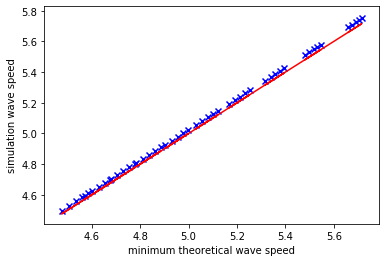

In [7]:

fig = plt.figure()
plt.scatter([-x for x in S_sel],[-x for x in S_simu], marker='x', c='b')
plt.ylabel('simulation wave speed')
plt.xlabel('minimum theoretical wave speed')
plt.plot([-x for x in S_sel],[-x for x in S_sel], c='r')
plt.show()

/usr/lib/python3.7/site-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


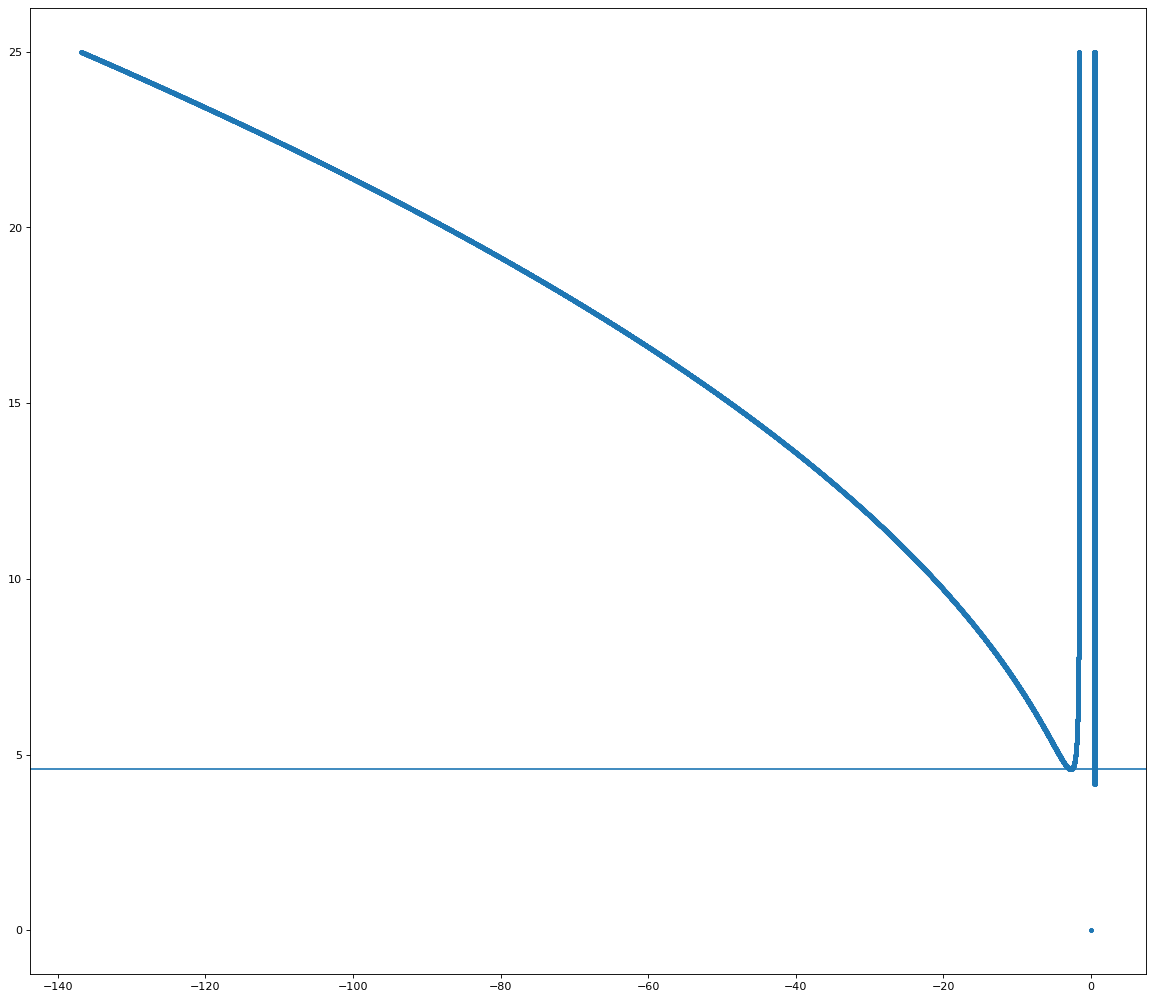

In [9]:
def plot_roots():
    X =[]
    for n in np.linspace(0,50,10000):
        s = n/2
        roots = np.roots([1]+[s**2*x/Temp for x in coeffs_P3()])
        roots = roots[np.isreal(roots)]
        for i in range(len(roots)):
            X+=[[s,roots[i]]]

    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    S = []
    Root = []
    for i in range(len(X)):
        S += [X[i][0]]
        Root += [X[i][1]]
    plt.figsize=(3,3)
   # plt.axis((-20,1,0,2*vitesse_theorique(sign=1)))
    plt.scatter(Root,S, marker='.')
    plt.axhline(y=vitesse_theorique(sign=1))
plot_roots()

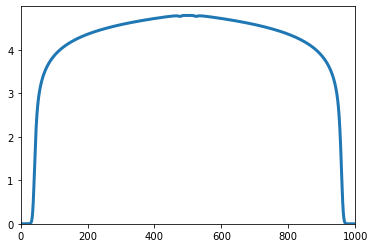

In [10]:
fig = plt.figure()
ax = plt.axes(xlim=(0, Lx), ylim=(0, Rho_mem[-1][Nx//2]+.2))
line, = ax.plot([], [], lw=3)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(X,Rho_mem[20*i][:])
    return line,

ani = animation.FuncAnimation(fig, animate,init_func=init,frames= len(Mu_mem)//20, interval=50, blit=True)

from IPython.display import HTML
HTML(ani.to_jshtml())